Name: **Moogambigai A**

Reg No: **3122237001027**



PART 1: LINEAR REGRESSION (Mobile Phone Price Prediction)

Step 1. Import Libraries and Define Helper Functions

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42

# Function to add intercept term
def add_intercept(X):
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

# Closed-form (normal equation)
def normal_eq(X, y, l2=0.0):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # do not regularize intercept
    return np.linalg.pinv(X.T @ X + l2 * I) @ (X.T @ y)

# Prediction function
def predict(X, theta):
    return X @ theta

# Gradient Descent Implementation
def gradient_descent(X, y, lr=1e-3, n_iters=10000, l2=0.0, tol=1e-8):
    m, n = X.shape
    theta = np.zeros(n)
    prev_loss = np.inf

    for i in range(n_iters):
        preds = X @ theta
        error = preds - y
        grad = (1/m) * (X.T @ error) + (l2/m) * np.r_[0, theta[1:]]
        theta -= lr * grad

        loss = (1/(2*m)) * np.sum(error**2)
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss
    return theta


Step 2. Load Dataset and Prepare Train/Test Sets

In [2]:
# Load your dataset
mobile = pd.read_csv("/content/Mobile-Price-Prediction-cleaned_data.csv")

# Check columns
print(mobile.head())

# Detect target column automatically
target_candidates = [c for c in mobile.columns if 'price' in c.lower()]
target_col = target_candidates[0] if target_candidates else mobile.columns[-1]
print("Using target column:", target_col)

# Features and target
X = mobile.drop(columns=[target_col]).select_dtypes(include=[np.number]).values
y = mobile[target_col].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


   Ratings  RAM    ROM  Mobile_Size  Primary_Cam  Selfi_Cam  Battery_Power  \
0      4.3  4.0  128.0         6.00           48       13.0           4000   
1      3.4  6.0   64.0         4.50           48       12.0           4000   
2      4.3  4.0    4.0         4.50           64       16.0           4000   
3      4.4  6.0   64.0         6.40           48       15.0           3800   
4      4.5  6.0  128.0         6.18           35       15.0           3800   

   Price  
0  24999  
1  15999  
2  15000  
3  18999  
4  18999  
Using target column: Price


Step 3. Closed-Form Solution

In [3]:
X_train_int = add_intercept(X_train)
X_test_int = add_intercept(X_test)

theta_closed = normal_eq(X_train_int, y_train)
y_pred_closed = predict(X_test_int, theta_closed)

print("Closed-form MSE:", mean_squared_error(y_test, y_pred_closed))
print("Closed-form R²:", r2_score(y_test, y_pred_closed))


Closed-form MSE: 239357657.42978132
Closed-form R²: 0.4332281397249509


Step 4. Gradient Descent Solution

In [5]:
from sklearn.preprocessing import StandardScaler

# Scale the features for Gradient Descent
scaler_gd = StandardScaler()
X_train_scaled = scaler_gd.fit_transform(X_train_int)
X_test_scaled = scaler_gd.transform(X_test_int)

theta_gd = gradient_descent(X_train_scaled, y_train, lr=0.001, n_iters=20000)
y_pred_gd = predict(X_test_scaled, theta_gd)

print("Gradient Descent MSE:", mean_squared_error(y_test, y_pred_gd))
print("Gradient Descent R²:", r2_score(y_test, y_pred_gd))

Gradient Descent MSE: 453014018.7566579
Gradient Descent R²: -0.07268595832038338


Step 5. Plot Predicted vs Actual (Comparison)

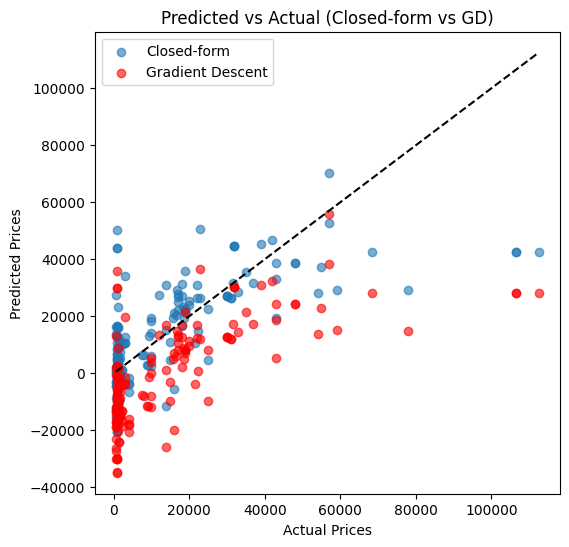

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_closed, alpha=0.6, label="Closed-form")
plt.scatter(y_test, y_pred_gd, alpha=0.6, label="Gradient Descent", color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("Predicted vs Actual (Closed-form vs GD)")
plt.show()


Step 6. Ridge Regression (L2 Regularization)

In [7]:
l2 = 1.0
theta_ridge = normal_eq(X_train_int, y_train, l2=l2)
y_pred_ridge = predict(X_test_int, theta_ridge)

print(f"Ridge Regression (λ={l2}) MSE:", mean_squared_error(y_test, y_pred_ridge))


Ridge Regression (λ=1.0) MSE: 238951584.5159223


Step 7. With and Without Standardization

In [8]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

X_train_s_int = add_intercept(X_train_s)
X_test_s_int = add_intercept(X_test_s)

theta_ridge_std = normal_eq(X_train_s_int, y_train, l2=l2)
y_pred_ridge_std = predict(X_test_s_int, theta_ridge_std)

print("Without Standardization MSE:", mean_squared_error(y_test, y_pred_ridge))
print("With Standardization MSE:", mean_squared_error(y_test, y_pred_ridge_std))


Without Standardization MSE: 238951584.5159223
With Standardization MSE: 239200533.96478516


Step 8. Feature Importance from Ridge Weights

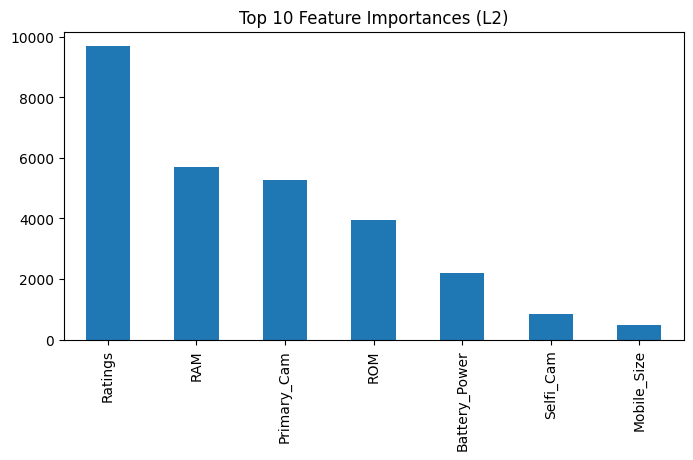

In [9]:
feature_names = mobile.drop(columns=[target_col]).select_dtypes(include=[np.number]).columns
weights = theta_ridge_std[1:]
importance = pd.Series(np.abs(weights), index=feature_names).sort_values(ascending=False)

importance.head(10).plot(kind="bar", figsize=(8,4), title="Top 10 Feature Importances (L2)")
plt.show()


PART 2: LINEAR CLASSIFICATION (Bank Note Authentication)

Step 1. Load and Split Dataset

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

bank = pd.read_csv("/content/BankNote_Authentication.csv")
print(bank.head())

Xb = bank.iloc[:, :-1].values
yb = bank.iloc[:, -1].values

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=RANDOM_STATE)


   variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0


Step 2. Logistic Regression with/without Regularization

In [12]:
# Without L2 (penalty='none')
clf_none = LogisticRegression(penalty=None, solver='saga', max_iter=5000)
clf_none.fit(Xb_train, yb_train)

# With L2
clf_l2 = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=5000)
clf_l2.fit(Xb_train, yb_train)

print("No Regularization -> Train acc:", accuracy_score(yb_train, clf_none.predict(Xb_train)),
      "| Test acc:", accuracy_score(yb_test, clf_none.predict(Xb_test)))

print("With L2 -> Train acc:", accuracy_score(yb_train, clf_l2.predict(Xb_train)),
      "| Test acc:", accuracy_score(yb_test, clf_l2.predict(Xb_test)))

No Regularization -> Train acc: 0.9927073837739289 | Test acc: 0.9854545454545455
With L2 -> Train acc: 0.99179580674567 | Test acc: 0.9854545454545455


Step 3. Accuracy vs λ Plot

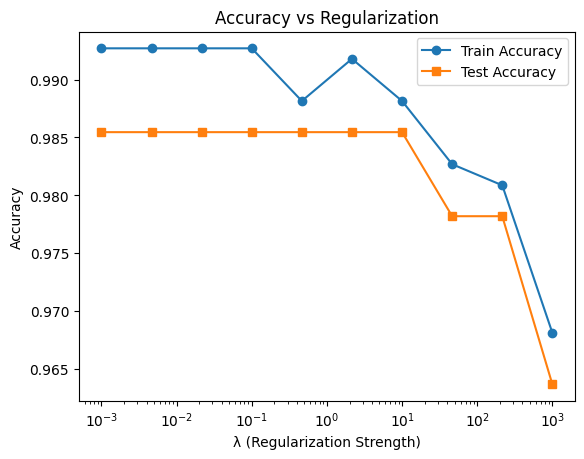

In [13]:
lambdas = np.logspace(-3, 3, 10)
train_acc, test_acc = [], []

for lam in lambdas:
    C = 1.0 / lam
    clf = LogisticRegression(penalty='l2', C=C, solver='saga', max_iter=5000)
    clf.fit(Xb_train, yb_train)
    train_acc.append(accuracy_score(yb_train, clf.predict(Xb_train)))
    test_acc.append(accuracy_score(yb_test, clf.predict(Xb_test)))

plt.semilogx(lambdas, train_acc, 'o-', label='Train Accuracy')
plt.semilogx(lambdas, test_acc, 's-', label='Test Accuracy')
plt.xlabel('λ (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization')
plt.legend()
plt.show()


Step 4. Visualize Data in 3D

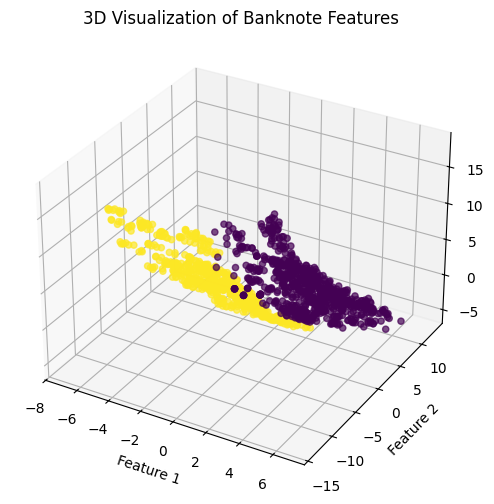

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xb[:,0], Xb[:,1], Xb[:,2], c=yb, cmap='viridis', alpha=0.7)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('3D Visualization of Banknote Features')
plt.show()


Step 5. Add Outliers and Refit

In [15]:
# Add noise to 1% of training data
Xb_train_out = Xb_train.copy()
n_out = int(0.01 * len(Xb_train))
np.random.seed(RANDOM_STATE)
out_idx = np.random.choice(len(Xb_train), n_out, replace=False)
Xb_train_out[out_idx] += np.random.normal(50, 10, size=Xb_train_out[out_idx].shape)

clf_out = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=5000)
clf_out.fit(Xb_train_out, yb_train)

print("With Outliers -> Train acc:", accuracy_score(yb_train, clf_out.predict(Xb_train_out)),
      "| Test acc:", accuracy_score(yb_test, clf_out.predict(Xb_test)))


With Outliers -> Train acc: 0.9434822242479489 | Test acc: 0.9163636363636364
